In [ ]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import re
import plotly.graph_objects as go
import gdown
import zipfile
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np


#  loading date

In [ ]:
# Google Drive URL
zip_url = "https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6"

# Function to download and read the zip archive containing CSV files
def download_and_read_csv_zip(zip_url):
    # Download the zip file from Google Drive
    output = 'archive.zip'
    gdown.download(zip_url, output, quiet=False)

    # Dictionary to store DataFrames
    dfs = {}

    # Open the zip file
    with zipfile.ZipFile(output, "r") as zip_ref:
        # Extract each CSV file from the zip archive
        for file_name in zip_ref.namelist():
            if file_name.endswith('.csv'):
                # Read the CSV file directly into a pandas DataFrame
                df = pd.read_csv(zip_ref.open(file_name), encoding='iso-8859-1')
                # Store the DataFrame in the dictionary
                dfs[file_name] = df

    return dfs

# Call the function with the zip URL
dfs = download_and_read_csv_zip(zip_url)

# View all DataFrames
for file_name, df in dfs.items():
    print("File:", file_name)
    print(df)
    print("="*50)


Downloading...
From (original): https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6
From (redirected): https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6&confirm=t&uuid=36f366a5-032f-4b0c-9412-9c6316c573e8
To: /content/archive.zip
100%|██████████| 45.0M/45.0M [00:01<00:00, 37.6MB/s]


File: S_Data/__MACOSX/._customers.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._geolocation.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_items.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_payments.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_reviews.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._orders.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._product_category_name_translation.csv
  Unnamed: 0
0        o\t
File: S_Data/__MACOSX/._products.csv
   Unnamed: 0
0          21
File: S_Data/__MACOSX/._sellers.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/customers.csv
                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac

# Task 2. Analysis of sellers and products
In this block, I would like to see analytics of sellers and products presented on our marketplace. You have been provided with the following data: sellers, products – based on them, you need to build an analytical report, including: the sellers with the biggest/smallest turnover, leaders/outsiders in sales in each area. For products, we are interested in turnover analytics, which products sell best in each category, as well as the dependence of product weight on turnover and price. It is also interesting to see the segmentation of sellers and products with textual conclusions regarding the business value of using these results.

In [ ]:
file_name ='S_Data/orders.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    orders = dfs[file_name]

else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
timestamp_cols = ['order_purchase_timestamp']
for col in timestamp_cols:
    orders[col] = pd.to_datetime(orders[col])

# Extracting attributes for purchase date - Year and Month
orders['order_purchase_year'] = orders['order_purchase_timestamp'].apply(lambda x: x.year)
orders['order_purchase_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.month)
orders['order_purchase_month_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
orders['order_purchase_year_month'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
orders['order_purchase_date'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
orders['order_purchase_day'] = orders['order_purchase_timestamp'].apply(lambda x: x.day)
orders['order_purchase_dayofweek'] = orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
orders['order_purchase_dayofweek_name'] = orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
orders['order_purchase_hour'] = orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
orders['order_purchase_time_day'] = pd.cut(orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# Delete 2016 data

In [ ]:
file_name ='S_Data/order_payments.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    order_payments = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
order_payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [ ]:
order_payments.duplicated().sum()

0

In [ ]:
file_name = 'S_Data/order_items.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    order_items = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [ ]:
order_items.duplicated().sum()

0

In [ ]:
price = order_items.groupby("order_id").agg({ 'price': 'sum', 'freight_value': 'sum'}).reset_index()
price["total"] = price["price"] + price["freight_value"]
price


#We join the prices of the dataframe with the dataframe of orders, to calculate the sales by year, month, etc.
sales = pd.merge(price, orders, on="order_id")
sales.head()

,order_id,price,freight_value,total,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,...,2017,9,Sep,201709,20170913,13,2,Wed,8,Morning
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,...,2017,4,Apr,201704,20170426,26,2,Wed,10,Morning
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,...,2018,1,Jan,201801,20180114,14,6,Sun,14,Afternoon
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,...,2018,8,Aug,201808,20180808,8,2,Wed,10,Morning
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,...,2017,2,Feb,201702,20170204,4,5,Sat,13,Afternoon


In [ ]:
sales_year_month = sales.groupby(by=["order_purchase_year", "order_purchase_year_month","order_purchase_month_name"]).agg({"order_id": "count","price": "sum","freight_value": "sum","total": "sum"}).reset_index()
sales_year_month.head()

,order_purchase_year,order_purchase_year_month,order_purchase_month_name,order_id,price,freight_value,total
0,2016,201609,Sep,3,267.36,87.39,354.75
1,2016,201610,Oct,308,49507.66,7301.18,56808.84
2,2016,201612,Dec,1,10.90,8.72,19.62
3,2017,201701,Jan,789,120312.87,16875.62,137188.49
4,2017,201702,Feb,1733,247303.02,38977.60,286280.62


In [ ]:
#sales_year = sales.groupby(by=["order_purchase_year"]).agg({"order_id": "count","price": "sum","freight_value": "sum","total": "sum"}).reset_index()
sales_year = sales.groupby(by=["order_purchase_year"]).agg({"total": "sum"}).reset_index()
sales_year

,order_purchase_year,total
0,2016,57183.21
1,2017,7142672.43
2,2018,8643697.60


In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as tkr
import matplotlib as mpl

# Define a function to format the y-axis ticks
def format_thousand_real_y(value, tick_number):
    return f'R${value:,.0f}'

# Create a formatter using the defined function
formatter_thousand_real_y = FuncFormatter(format_thousand_real_y)


In [ ]:
def millons_real_y(y, pos):
    return 'R${:.1f} M'.format(y*1e-6)
formatter_millons_real_y = FuncFormatter(millons_real_y)
#ax2.yaxis.set_major_formatter(formatter_millons_real_y)

Text(0.5, 0.98, '')

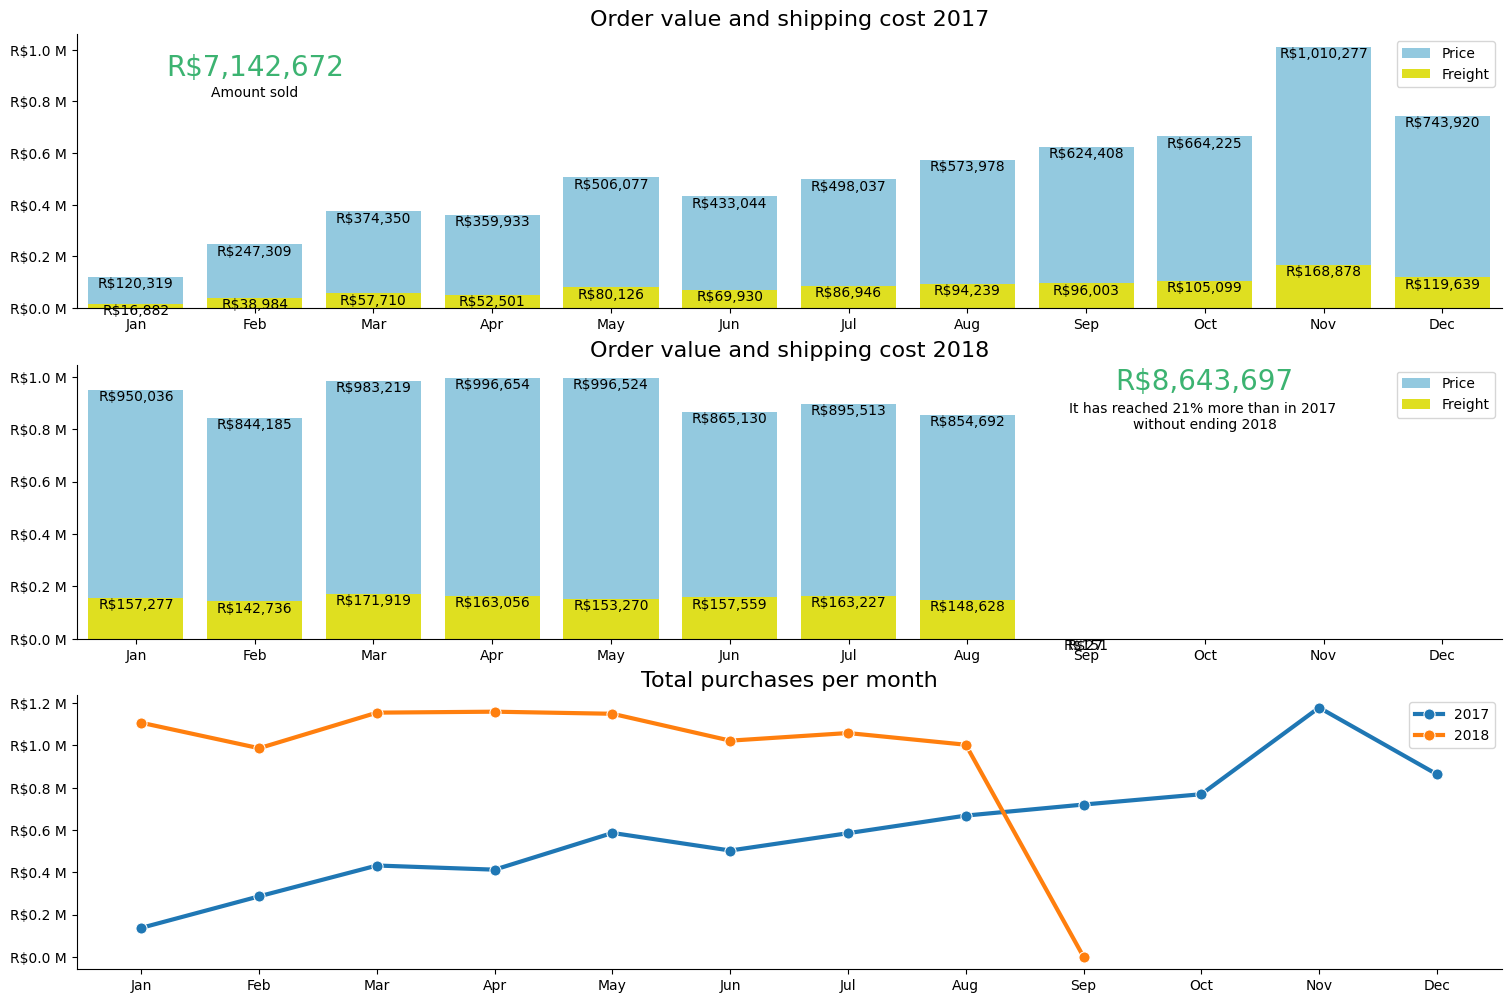

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2,:])



month_order= ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

sns.barplot(x="order_purchase_month_name", y="price", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2017], order=month_order, ax=ax1, color="skyblue", label="Price")
sns.barplot(x="order_purchase_month_name", y="freight_value", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2017], order=month_order, ax=ax1, color="yellow", label="Freight")

ax1.set_title("Order value and shipping cost 2017", size=16)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.legend(loc="upper right")
for p in ax1.patches:
  ax1.annotate('R${:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='top',
                    color= 'black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_major_formatter(formatter_millons_real_y)

ax1.text(1, 900000, f'R$7,142,672', fontsize=20, color='mediumseagreen', ha='center')
ax1.text(1, 820000, 'Amount sold', fontsize=10, ha='center')


sns.barplot(x="order_purchase_month_name", y="price", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2018], order=month_order, ax=ax2, color="skyblue", label="Price")
sns.barplot(x="order_purchase_month_name", y="freight_value", data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2018], order=month_order, ax=ax2, color="yellow", label="Freight")
ax2.set_title("Order value and shipping cost 2018", size=16)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.legend(loc="upper right")
for p in ax2.patches:
        ax2.annotate('R${:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='top',
                    color= 'black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.yaxis.set_major_formatter(formatter_millons_real_y)

ax2.text(9, 950000, f'R$8,643,697', fontsize=20, color='mediumseagreen', ha='center')
ax2.text(9, 800000, 'It has reached 21% more than in 2017 \nwithout ending 2018', fontsize=10, ha='center')

sns.lineplot(x="order_purchase_month_name", y='total', data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2017], ax=ax3,linewidth=3.0, label="2017", marker='o', markersize=8)
sns.lineplot(x="order_purchase_month_name", y='total', data=sales_year_month.loc[sales_year_month["order_purchase_year"]==2018], ax=ax3,linewidth=3.0,label="2018", marker='o', markersize=8)
ax3.set_title("Total purchases per month", size=16, color='black')
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.yaxis.set_major_formatter(formatter_millons_real_y)

plt.suptitle("")

In [ ]:
# Specify the file name you want to retrieve
file_name ='S_Data/products.csv'

# Check if the file exists in the dictionary
if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    products = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
file_name ='S_Data/product_category_name_translation.csv'
# Check if the file exists in the dictionary
if file_name in dfs:
    # Access the DataFrame corresponding to the file name
   product_category_name_translation = dfs[file_name]

else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
product_category_name_translation.columns

Index(['ï»¿product_category_name', 'product_category_name_english'], dtype='object')

In [ ]:
product_category_name_translation.rename(columns={'ï»¿product_category_name':'product_category_name'}, inplace=True)


In [ ]:
products = products.merge(product_category_name_translation, on ='product_category_name', how = 'left' )
#products = product_details.merge(product_translate, on='product_category_name', how='left')
products.isna().sum()

product_id                         0
product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64

In [ ]:
 #filling the missing values in product_category_name_english where there are values in product_category_name
products['product_category_name_english'] = np.where(products["product_category_name"] == 'portateis_cozinha_e_preparadores_de_alimentos',
                                                     'kitchen_portable_and_food_preparers', products['product_category_name_english'])

products['product_category_name_english'] = np.where(products["product_category_name"] == 'pc_gamer',
                                                     'pc_gaming', products['product_category_name_english'])

In [ ]:
products['product_category_name'].fillna('not_defined_product', inplace= True)
products['product_category_name_english'].fillna('not_defined_product', inplace= True)

# filling with 0 for another missing numeric values
products.fillna(0, inplace=True)

# checking missing values again
products.isna().sum()

product_id                       0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
dtype: int64

In [ ]:
products.rename(columns={'product_category_name_english': 'product_name'}, inplace=True)

In [ ]:
products.duplicated().sum()


0

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  float64
 3   product_description_lenght  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
 9   product_name                32951 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.5+ MB


In [ ]:
products = pd.merge(order_items, products, on="product_id")

In [ ]:
#We calculate the total that the customer paid for the product
products["total"] = products["price"] + products["freight_value"]
#new dataframe with the columns we just need
products = products[["order_id", "product_id", "price" , "freight_value", "total", "product_name"]]
orderedProducts = products.copy()
#products

#We join our dataframe products with orders to obtain the information of the dates
products = pd.merge(products, orders, on="order_id")
#products

#new dataframe with the columns we just need
products = products[["product_id", "price" , "freight_value", "total", "product_name", "order_purchase_year", "order_purchase_month_name","order_purchase_year_month"]]
products["product_category_name_english"] = products["product_name"].str.capitalize()
products.head()



,product_id,price,freight_value,total,product_name,order_purchase_year,order_purchase_month_name,order_purchase_year_month,product_category_name_english
0,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,72.19,cool_stuff,2017,Sep,201709,Cool_stuff
1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,73.86,cool_stuff,2017,Jun,201706,Cool_stuff
2,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,83.23,cool_stuff,2018,May,201805,Cool_stuff
3,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,75.07,cool_stuff,2017,Aug,201708,Cool_stuff
4,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,72.19,cool_stuff,2017,Aug,201708,Cool_stuff


In [ ]:
orderedProductsAnalysis = orderedProducts.groupby('product_name', as_index = False).agg({
                                                        'product_id'                      : 'count',
                                                        'order_id'                        : 'count',
                                                        'price'                           : 'sum',
                                                        'freight_value'                   : 'sum',
                                                        'total'                   : 'sum'})
orderedProductsAnalysis

,product_name,product_id,order_id,price,freight_value,total
0,agro_industry_and_commerce,212,212,72530.47,5843.60,78374.07
1,air_conditioning,297,297,55024.96,6749.23,61774.19
2,art,209,209,24202.64,4045.17,28247.81
3,arts_and_craftmanship,24,24,1814.01,370.13,2184.14
4,audio,364,364,50688.50,5710.44,56398.94
...,...,...,...,...,...,...
69,stationery,2517,2517,230943.23,46798.48,277741.71
70,tablets_printing_image,83,83,7528.41,1226.20,8754.61
71,telephony,4545,4545,323667.53,71215.79,394883.32
72,toys,4117,4117,483946.60,77425.95,561372.55


In [ ]:
top10revenueGenerating = orderedProducts.sort_values(by = 'total', ascending = False)[:10]
top10revenueGenerating

,order_id,product_id,price,freight_value,total,product_name
37101,0812eb902a67711a1cb742b3cdaa65ae,489ae2aa008f021502940f251d4cce7f,6735.00,194.31,6929.31,housewares
112569,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,6729.00,193.21,6922.21,computers
111726,f5136e38d1a14a4dbd87dff67da82701,1bdf5e6731585cf01aa8169c7028d6ad,6499.00,227.66,6726.66,art
103335,a96610ab360d42a2e5335a3998b4718a,a6492cc69376c469ab6f61d8f44de961,4799.00,151.34,4950.34,small_appliances
60252,199af31afc78c699f0dbf71fb178d4d4,c3ed642d592594bb648ff4a04cee2747,4690.00,74.34,4764.34,small_appliances
99306,8dbc85d1447242f3b127dda390d56e19,259037a6a41845e455183f89c5035f18,4590.00,91.78,4681.78,computers
81704,426a9742b533fc6fed17d1fd6d143d7e,a1beef8f3992dbd4cd8726796aa69c53,4399.87,113.45,4513.32,musical_instruments
97219,80dfedb6d17bf23539beeef3c768f4d7,4ca7b91a31637bd24fb8e559d5e015e4,3999.00,195.76,4194.76,small_appliances
92236,68101694e5c5dc7330c91e1bbc36214f,6cdf8fc1d741c76586d8b6b15e9eef30,4099.99,75.27,4175.26,consoles_games
102761,b239ca7cd485940b31882363b52e6674,dd113cb02b2af9c8e5787e8f1f0722f6,4059.00,104.51,4163.51,sports_leisure


In [ ]:
#We group by category to generate the scatter plot
products_category = products.groupby("product_name").agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_year_month", ascending=False).head(20)
products_category.head()

,product_name,order_purchase_year_month,total
7,bed_bath_table,11115,1241681.72
43,health_beauty,9670,1441248.07
68,sports_leisure,8641,1156656.48
39,furniture_decor,8334,902511.79
15,computers_accessories,7827,1059272.40


In [ ]:
file_name ='S_Data/order_reviews.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    order_reviews = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [ ]:
#We group by category to generate the bar plot
products_category_year = products.groupby(by=["product_name","order_purchase_year"]).agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by=["order_purchase_year","order_purchase_year_month"], ascending=[True,False])
products_category_year.head()

,product_name,order_purchase_year,order_purchase_year_month,total
96,furniture_decor,2016,69,7188.51
106,health_beauty,2016,51,5636.84
149,perfumery,2016,33,6223.84
172,toys,2016,27,4986.08
37,computers_accessories,2016,21,1740.09


In [ ]:
products_cat_trends = products.groupby(by=["product_category_name_english","order_purchase_year_month"]).agg({"order_purchase_year" : "count","total" : "sum"}).reset_index().sort_values(by=["order_purchase_year_month","order_purchase_year","product_category_name_english"], ascending=[True,False,True])
#We remove the data from 2016, we are only analyzing 2017 and 2018
products_cat_trends.drop(products_cat_trends.loc[products_cat_trends["order_purchase_year_month"]=="201609"].index, inplace=True)
products_cat_trends.drop(products_cat_trends.loc[products_cat_trends["order_purchase_year_month"]=="201610"].index, inplace=True)
products_cat_trends.drop(products_cat_trends.loc[products_cat_trends["order_purchase_year_month"]=="201612"].index, inplace=True)

#We filter the categories that are in the Top 5 by category in 2017 y 2018
products_cat_trends = products_cat_trends[(products_cat_trends["product_category_name_english"]=="Bed_bath_table") |
                                  (products_cat_trends["product_category_name_english"]=="Furniture_decor")|
                                  (products_cat_trends["product_category_name_english"]=="Sports_leisure")|
                                  (products_cat_trends["product_category_name_english"]=="Health_beauty")|
                                  (products_cat_trends["product_category_name_english"]=="Computers_accessories")]
products_cat_trends.head()

,product_category_name_english,order_purchase_year_month,order_purchase_year,total
675,Furniture_decor,201701,182,16461.75
749,Health_beauty,201701,85,14039.74
1162,Sports_leisure,201701,80,11447.27
127,Bed_bath_table,201701,48,4817.27
254,Computers_accessories,201701,31,4377.60


<ipython-input-37-cbcda7b5035d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="product_name", y="order_purchase_year_month", data=products_category_year.loc[products_category_year["order_purchase_year"]==2017].head(5), ax=ax2, palette="Blues_r")
<ipython-input-37-cbcda7b5035d>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="product_name", y="order_purchase_year_month", data=products_category_year.loc[products_category_year["order_purchase_year"]==2018].head(5), ax=ax3, palette="Blues_r")


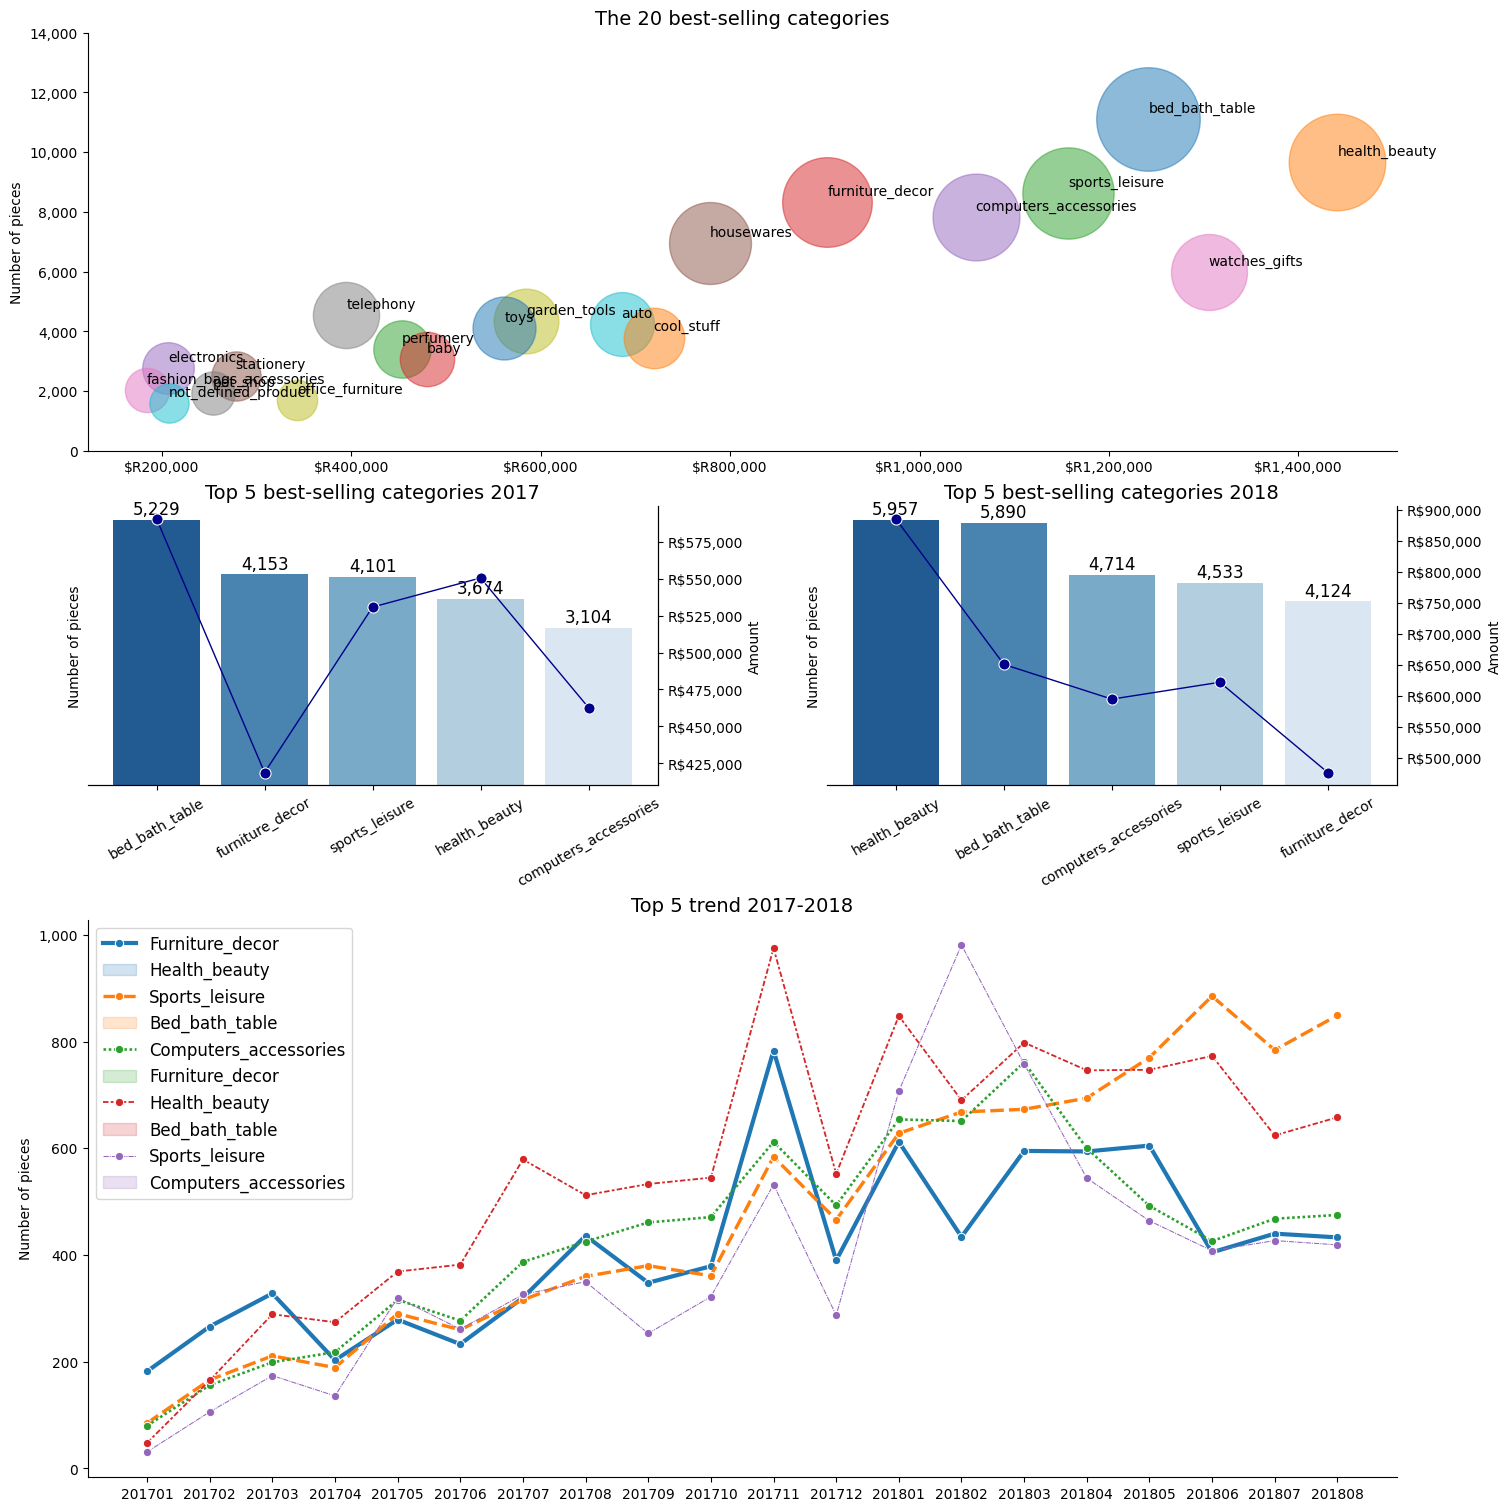

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))

# Axis definition
gs = GridSpec(9, 2, figure=fig)
ax1 = fig.add_subplot(gs[:3,0:])
ax2 = fig.add_subplot(gs[3:5, 0])
ax3 = fig.add_subplot(gs[3:5, 1])
ax4 = fig.add_subplot(gs[5:,0:])

for product in products_category["product_name"].unique():
    data = products_category[products_category["product_name"] == product]
    ax1.scatter(data['total'],data['order_purchase_year_month'],
                s=0.5*data['order_purchase_year_month']**1,
                alpha = 0.5,
                label=product)

for index, row in products_category.iterrows():
    ax1.annotate(row['product_name'],
                 (row['total'], row['order_purchase_year_month']),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='left')

ax1.set_xlabel("")
ax1.set_ylabel("Number of pieces")
ax1.set_title("The 20 best-selling categories",size=14)
ax1.set_ylim(0,14000)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('$R{x:,.0f}'))
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

sns.barplot(x="product_name", y="order_purchase_year_month", data=products_category_year.loc[products_category_year["order_purchase_year"]==2017].head(5), ax=ax2, palette="Blues_r")
ax2.set_xlabel("")
ax2.set_ylabel("Number of pieces")
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_title("Top 5 best-selling categories 2017", size=14)
#ax2.set_ylim(0,6000)
plt.setp(ax2.get_xticklabels(), rotation=30)
for p in ax2.patches:
        ax2.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
#ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2_twx = ax2.twinx()
sns.lineplot(x="product_name", y='total', data=products_category_year.loc[products_category_year["order_purchase_year"]==2017].head(5), ax=ax2_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
#ax2_twx.set_ylim(0,990000)
ax2_twx.set_ylabel("Amount")
ax2_twx.spines['top'].set_visible(False)
ax2_twx.spines['left'].set_visible(False)
ax2_twx.yaxis.set_major_formatter(formatter_thousand_real_y)

sns.barplot(x="product_name", y="order_purchase_year_month", data=products_category_year.loc[products_category_year["order_purchase_year"]==2018].head(5), ax=ax3, palette="Blues_r")
ax3.set_xlabel("")
ax3.set_ylabel("Number of pieces")
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_title("Top 5 best-selling categories 2018", size=14)
for p in ax3.patches:
        ax3.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
plt.setp(ax3.get_xticklabels(), rotation=30)
ax3_twx = ax3.twinx()
sns.lineplot(x="product_name", y='total', data=products_category_year.loc[products_category_year["order_purchase_year"]==2018].head(5), ax=ax3_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
#ax3_twx.set_ylim(0,990000)
ax3_twx.set_ylabel("Amount")
ax3_twx.yaxis.set_major_formatter(formatter_thousand_real_y)
ax3_twx.spines['top'].set_visible(False)
ax3_twx.spines['top'].set_visible(False)
ax3_twx.spines['left'].set_visible(False)

sns.lineplot(x='order_purchase_year_month', y='order_purchase_year', data=products_cat_trends, ax=ax4, hue='product_category_name_english',legend=False, style='product_category_name_english', size='product_category_name_english', marker='o', linewidth=3)
ax4.legend(labels=products_cat_trends["product_category_name_english"], loc='upper left', fontsize=12)
ax4.set_title("Top 5 trend 2017-2018", size=14)
ax4.set_ylabel("Number of pieces")
ax4.set_xlabel("")
ax4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

In [ ]:
products_top = products.groupby(by=["product_id","product_category_name_english"]).agg({"order_purchase_month_name" : "count","total" : "sum"}).reset_index().sort_values(by="order_purchase_month_name", ascending=False).head(10)
products_top.head()

,product_id,product_category_name_english,order_purchase_month_name,total
22112,aca2eb7d00ea1a7b8ebd4e68314663af,Furniture_decor,527,44820.76
19742,99a4788cb24856965c36a24e339b6058,Bed_bath_table,488,51071.60
8613,422879e10f46682990de24d770e7f83d,Garden_tools,484,34201.26
7364,389d119b48cf3043d311335e499d9c6b,Garden_tools,392,28682.68
7079,368c6c730842d78016ad823897a372db,Garden_tools,388,27984.40


In [ ]:
products_top_year = products.groupby(by=["product_id","order_purchase_year"]).agg({"order_purchase_year_month" : "count","total" : "sum"}).reset_index().sort_values(by=["order_purchase_year","order_purchase_year_month"], ascending=[True,False])
#We remove the data from 2016, we are only analyzing 2017 and 2018
products_top_year.drop(products_top_year.loc[products_top_year["order_purchase_year"]==2016].index, inplace=True)
products_top_year.head()

,product_id,order_purchase_year,order_purchase_year_month,total
22750,99a4788cb24856965c36a24e339b6058,2017,359,37819.85
9909,422879e10f46682990de24d770e7f83d,2017,276,20412.97
3207,154e7e31ebfa092203795c972e5804a6,2017,225,8021.22
8457,389d119b48cf3043d311335e499d9c6b,2017,219,16226.68
12509,53759a2ecddad2bb87a079a1f1519f73,2017,218,16239.55


<ipython-input-40-033fdfed2418>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="order_purchase_month_name", y="product_id",  data=products_top, ax=ax1, palette="rocket")
<ipython-input-40-033fdfed2418>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total", y="product_id",  data=products_top, ax=ax2, palette="rocket")
<ipython-input-40-033fdfed2418>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="product_id", y="order_purchase_year_month", data=products_top_year.loc[products_top_year["order_purchase_year"]==2017].head(10), ax=

Text(0.5, 0.98, 'Number of Pieces and Amount Sold \nby Products')

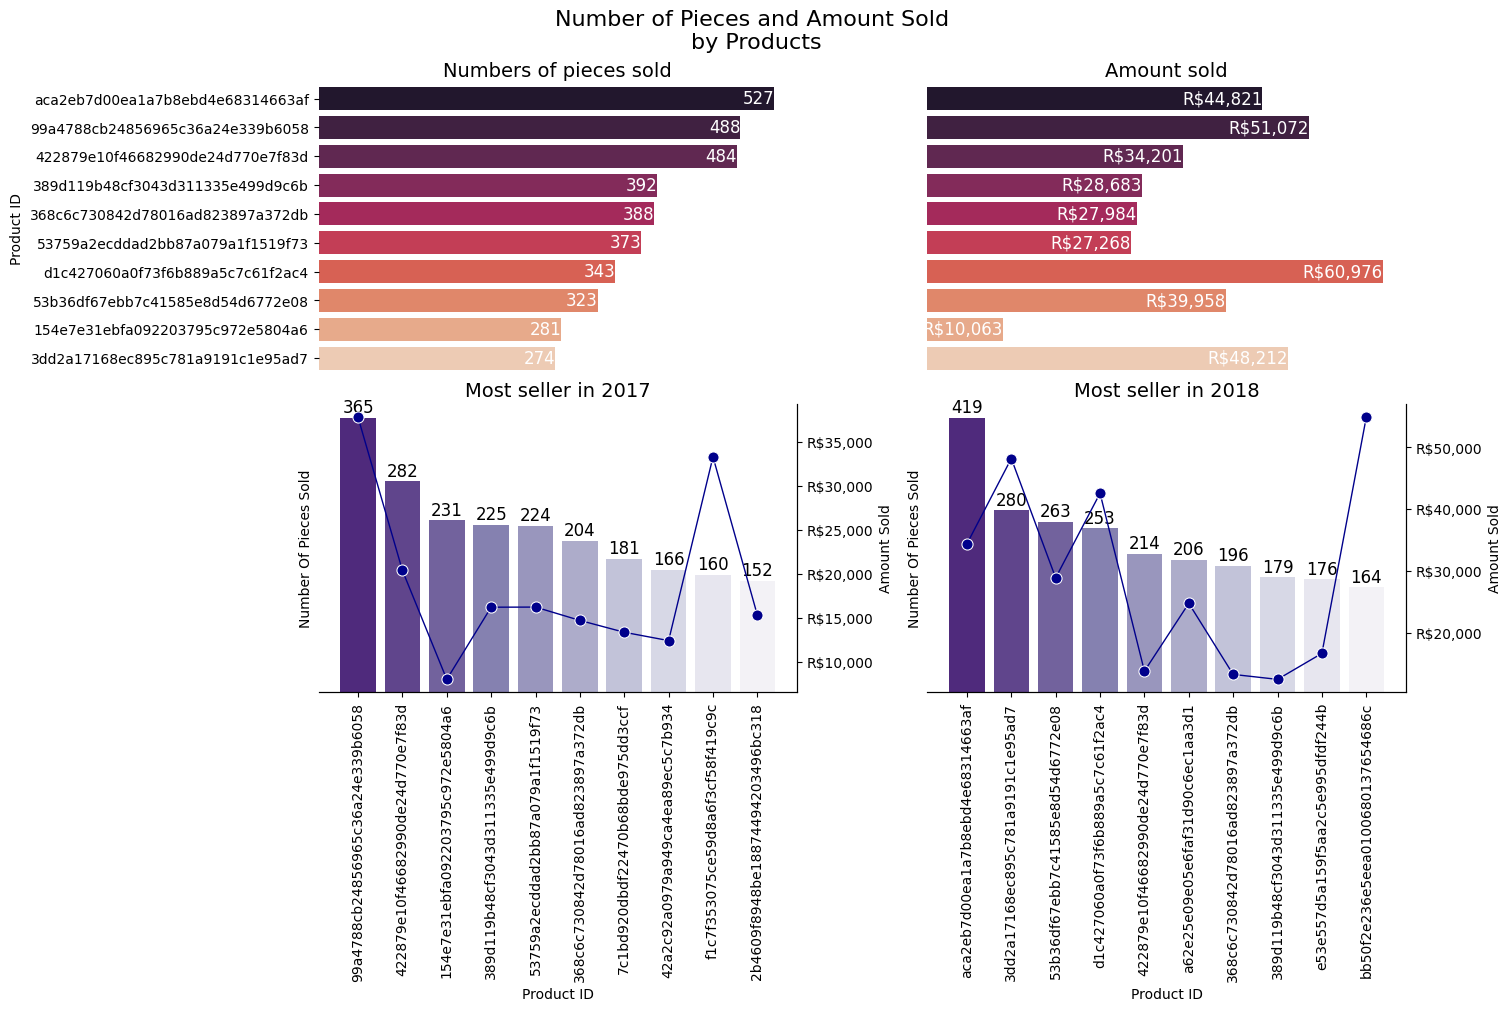

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[2:,0])
ax4 = fig.add_subplot(gs[2:,1])

sns.barplot(x="order_purchase_month_name", y="product_id",  data=products_top, ax=ax1, palette="rocket")
ax1.set_xlabel("")
ax1.set_ylabel("Product ID")
ax1.set_title("Numbers of pieces sold",size=14)
for rect in ax1.patches:
    ax1.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='right', size=12, color="white")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
sns.barplot(x="total", y="product_id",  data=products_top, ax=ax2, palette="rocket")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title("Amount sold", size=14)
for rect in ax2.patches:
    ax2.annotate('R${:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='right', size=12, color="white")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

sns.barplot(x="product_id", y="order_purchase_year_month", data=products_top_year.loc[products_top_year["order_purchase_year"]==2017].head(10), ax=ax3, palette="Purples_r")
ax3.set_xlabel("Product ID")
ax3.set_ylabel("Number Of Pieces Sold")
plt.setp(ax3.get_xticklabels(), rotation=90)
ax3.set_title("Most seller in 2017", size=14)
ax3.set_yticklabels([])
ax3.set_yticks([])
for p in ax3.patches:
   ax3.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3_twx = ax3.twinx()
sns.lineplot(x="product_id", y='total', data=products_top_year.loc[products_top_year["order_purchase_year"]==2017].head(10), ax=ax3_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
ax3_twx.set_ylabel("Amount Sold")
ax3_twx.spines['top'].set_visible(False)
ax3_twx.spines['left'].set_visible(False)
ax3_twx.yaxis.set_major_formatter(formatter_thousand_real_y)

sns.barplot(x="product_id", y="order_purchase_year_month", data=products_top_year.loc[products_top_year["order_purchase_year"]==2018].head(10), ax=ax4, palette="Purples_r")
ax4.set_xlabel("Product ID")
ax4.set_ylabel("Number Of Pieces Sold")
plt.setp(ax4.get_xticklabels(), rotation=90)
ax4.set_title("Most seller in 2018", size=14)
ax4.set_yticklabels([])
ax4.set_yticks([])
for p in ax4.patches:
   ax4.annotate('{:,.0f}'.format(p.get_height()+5.9), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="bottom", xytext=(0, 1), textcoords="offset points",
                    color= 'black', size=12)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4_twx = ax4.twinx()
sns.lineplot(x="product_id", y='total', data=products_top_year.loc[products_top_year["order_purchase_year"]==2018].head(10), ax=ax4_twx, linewidth=1.0, color="darkblue", marker="o", markersize=8)
ax4_twx.set_ylabel("Amount Sold")
ax4_twx.spines['top'].set_visible(False)
ax4_twx.spines['left'].set_visible(False)
ax4_twx.yaxis.set_major_formatter(formatter_thousand_real_y)

plt.suptitle("Number of Pieces and Amount Sold \nby Products", size=16)

In [ ]:
# Specify the file name you want to retrieve
file_name ='S_Data/sellers.csv'

# Check if the file exists in the dictionary
if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    sellers = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [ ]:
#The 10 cities with the most sellers
sellers_by_city = sellers.groupby("seller_city").count()["seller_id"].reset_index().sort_values(by="seller_id",ascending=False).head(10)
sellers_by_city.rename(columns = {"seller_id":"total"}, inplace=True)
sellers_by_city.head()

,seller_city,total
517,sao paulo,694
159,curitiba,127
450,rio de janeiro,96
64,belo horizonte,68
442,ribeirao preto,52


In [ ]:
#The 10 states with the most sellers
sellers_by_states = sellers.groupby("seller_state").count()["seller_id"].reset_index().sort_values(by="seller_id",ascending=False).head(10)
sellers_by_states.rename(columns = {"seller_id":"total"}, inplace=True)
sellers_by_states.head()

,seller_state,total
22,SP,1849
15,PR,349
8,MG,244
20,SC,190
16,RJ,171


In [ ]:
topSellers = order_items.seller_id.value_counts()
# Display the top 5 sellers (leaders)
top_sellers = topSellers.head()
print("Top Sellers (Leaders):")
print(top_sellers)

# Display the sellers with the fewest orders (outsiders)
outsiders = topSellers.tail()
print("\nSellers with the Fewest Orders (Outsiders):")
print(outsiders)

Top Sellers (Leaders):
seller_id
6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
Name: count, dtype: int64

Sellers with the Fewest Orders (Outsiders):
seller_id
400f221ab83037c0ea78f1267da9624d    1
1746c1ae87ac63d530c7c943d0ac42e2    1
16bdc8cefd0e32a6f0824d296c5ad14a    1
ace601496e211a664100321f038f50af    1
13d95f0f6f73943d4ceffad0fc2cd32c    1
Name: count, dtype: int64


In [ ]:
# merge elements of the data frame (customer, purchase date) to know the trend of how many customers made their first purchase
sellers_x_date = pd.merge(order_items,orders, on = "order_id")
sellers_x_date = sellers_x_date.drop_duplicates(subset=["seller_id"])
sellers_x_date.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,2017,9,Sep,201709,20170913,13,2,Wed,8,Morning
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,2017,4,Apr,201704,20170426,26,2,Wed,10,Morning
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,2018,1,Jan,201801,20180114,14,6,Sun,14,Afternoon
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,2018,8,Aug,201808,20180808,8,2,Wed,10,Morning
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,2017,2,Feb,201702,20170204,4,5,Sat,13,Afternoon


<ipython-input-121-b1a25213f3e4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total", y="seller_city", data=sellers_by_city, ax=ax5, palette='viridis')
<ipython-input-121-b1a25213f3e4>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total", y="seller_state", data=sellers_by_states, ax=ax6, palette="YlGnBu")


Text(0.5, 0.98, ' Sellers (2017-2018)')

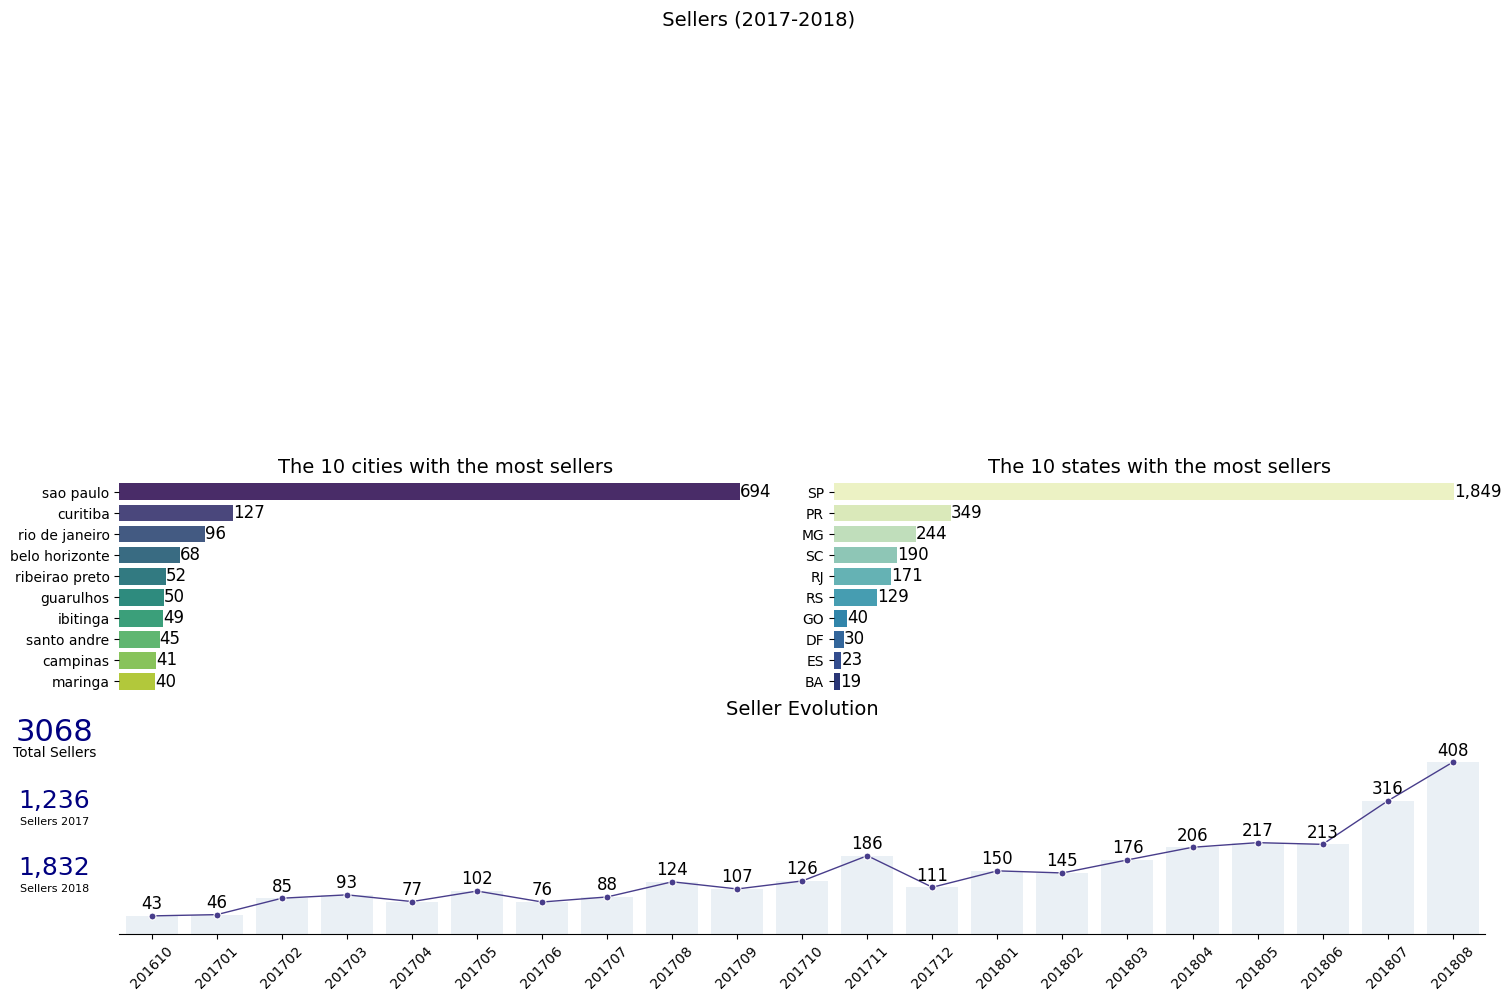

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(5, 2, figure=fig)
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
#ax7 = fig.add_subplot(gs[3, 1])
ax8 = fig.add_subplot(gs[3, :])

# Sellers city
sns.barplot(x="total", y="seller_city", data=sellers_by_city, ax=ax5, palette='viridis')
ax5.set_title("The 10 cities with the most sellers", size=14, color='black')
ax5.set_xlabel("")
ax5.set_ylabel("")
for rect in ax5.patches:
    ax5.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='left', size=12)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.axes.get_xaxis().set_visible(False)

# Sellers states
sns.barplot(x="total", y="seller_state", data=sellers_by_states, ax=ax6, palette="YlGnBu")
ax6.set_title("The 10 states with the most sellers", size=14, color='black')
ax6.set_xlabel("")
ax6.set_ylabel("")
for rect in ax6.patches:
    ax6.annotate('{:,.0f}'.format(rect.get_width()),(rect.get_width(),rect.get_y() + rect.get_height() / 2),
                xytext=(0, 0),textcoords='offset points', va='center', ha='left', size=12)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.spines['bottom'].set_visible(False)
ax6.axes.get_xaxis().set_visible(False)

#Sellers per year
sns.lineplot(x="order_purchase_year_month", y="order_id", data=sellers_x_date.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(),ax=ax8,
             color='darkslateblue', linewidth=1, marker='o', markersize=5)
sns.barplot(x="order_purchase_year_month", y="order_id", data=sellers_x_date.groupby("order_purchase_year_month").agg({"order_id" : "count"}).reset_index(),ax=ax8, alpha=0.1)
ax8.set_title("Seller Evolution", size=14, color="black")
ax8.set_xlabel("")
ax8.set_ylabel("")
ax8.set_ylim(0, 500)
plt.setp(ax8.get_xticklabels(), rotation=45)
for p in ax8.patches:
        ax8.annotate('{:,.0f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha="center", va="top", xytext=(0, 15), textcoords="offset points",
                    color= "black", size=12)
ax8.spines["top"].set_visible(False)
ax8.spines["right"].set_visible(False)
ax8.spines["left"].set_visible(False)
ax8.set_yticklabels([])
ax8.set_yticks([])
#Total de Sellers
ax8.text(-1.5, 460, "3068", fontsize=22, ha='center', color="navy")
ax8.text(-1.5, 420, "Total Sellers", fontsize=10, ha='center')
ax8.text(-1.5, 300, "1,236", fontsize=18, ha='center', color="navy")
ax8.text(-1.5, 260, "Sellers 2017", fontsize=8, ha='center')
ax8.text(-1.5, 140, "1,832", fontsize=18, ha='center', color="navy")
ax8.text(-1.5, 100, "Sellers 2018", fontsize=8, ha='center')


plt.suptitle(" Sellers (2017-2018)", size=14)


In [ ]:
# merge elements of the data frame (customer, purchase date) to know the trend of how many customers made their first purchase
sellers_x_date = pd.merge(order_items, orderedProducts, on = "order_id")
sellers_x_date = sellers_x_date.drop_duplicates(subset=['order_id'])
sellers_x_date = sellers_x_date.drop(columns=['product_id_x', 'price_x', 'freight_value_x'])
# Renaming columns to remove suffixes
sellers_x_date = sellers_x_date.rename(columns={
    'product_id_y': 'product_id',
    'price_y': 'price',
    'freight_value_y': 'freight_value'
})

sellers_x_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98666 entries, 0 to 157221
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             98666 non-null  object 
 1   order_item_id        98666 non-null  int64  
 2   seller_id            98666 non-null  object 
 3   shipping_limit_date  98666 non-null  object 
 4   product_id           98666 non-null  object 
 5   price                98666 non-null  float64
 6   freight_value        98666 non-null  float64
 7   total                98666 non-null  float64
 8   product_name         98666 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 7.5+ MB


In [ ]:
sellers_x_date.duplicated().sum()

0

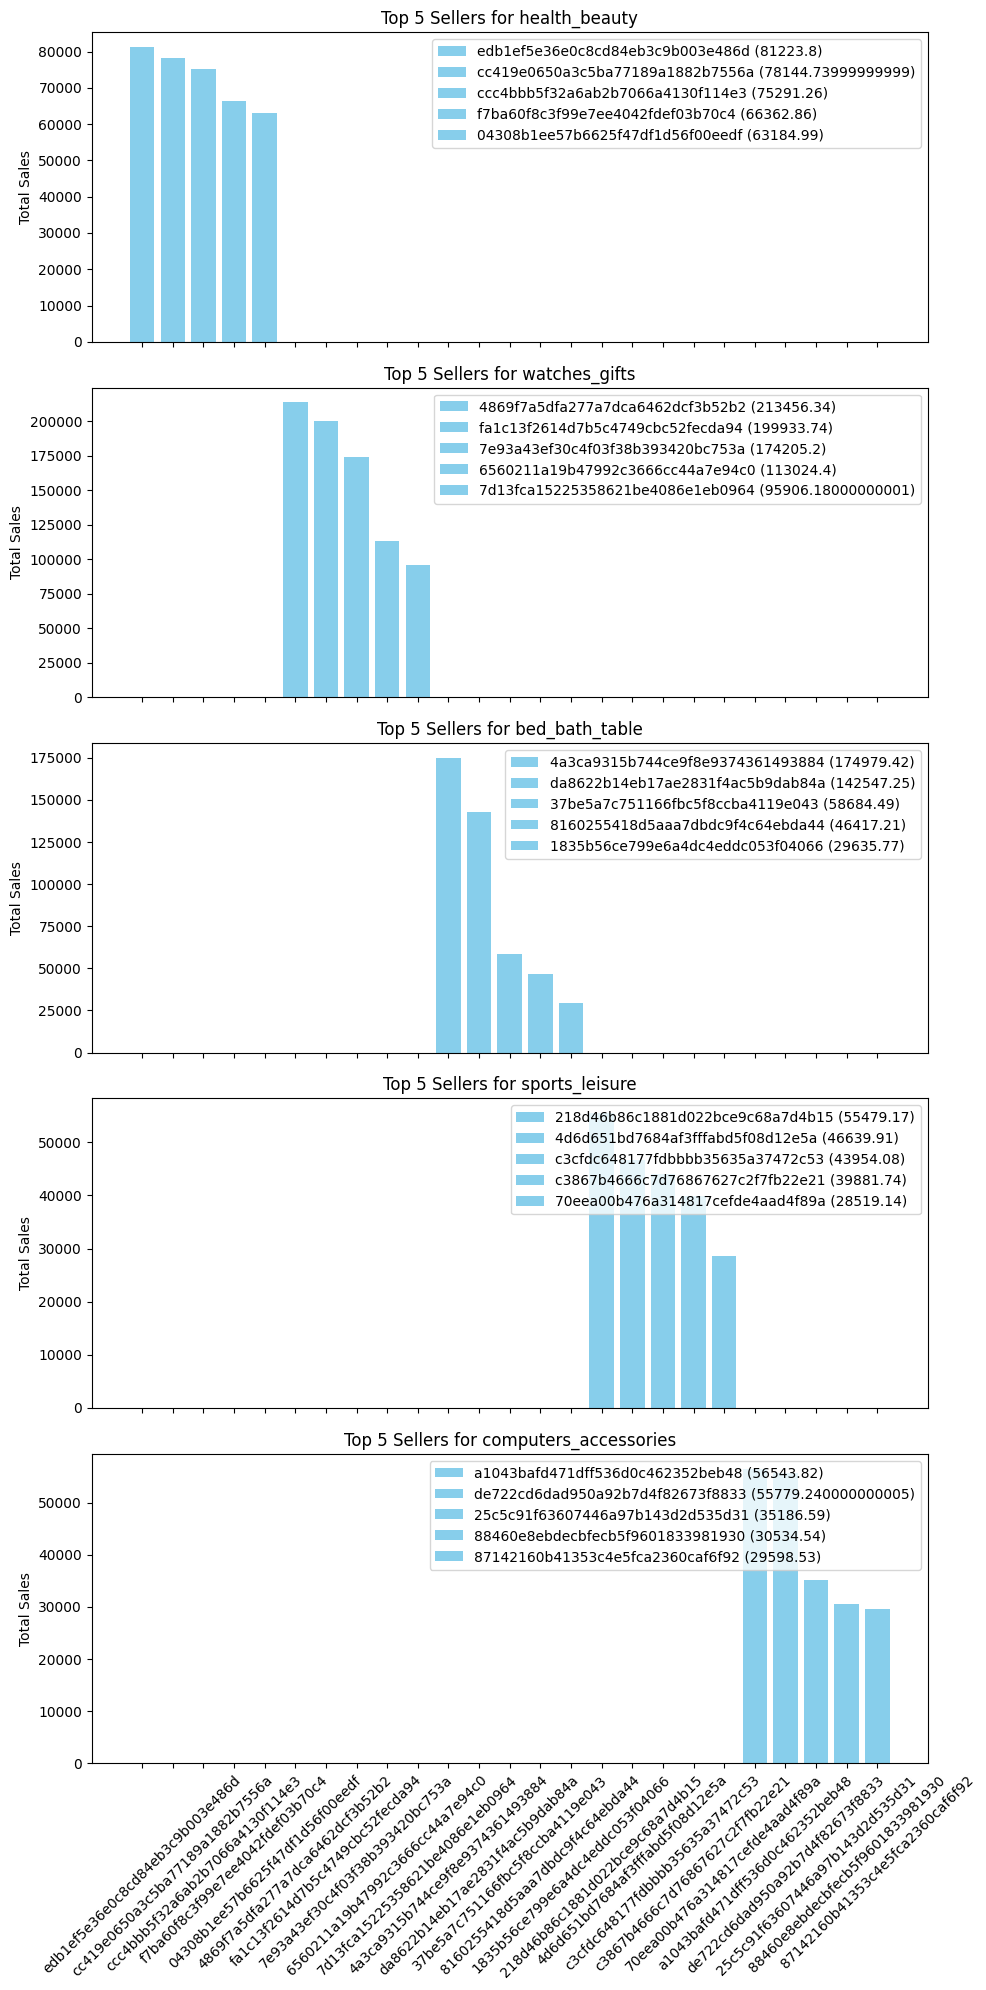

In [ ]:
df = sellers_x_date.copy
df = pd.DataFrame(sellers_x_date)

# Group by 'product_name' and 'seller_id', then sum the 'total' sales
sales_by_area = df.groupby(['product_name', 'seller_id'])['total'].sum().reset_index()

# Calculate total revenue for each seller within each category
seller_revenue = sales_by_area.groupby(['product_name', 'seller_id'])['total'].sum().reset_index()

# Sort categories by revenue and select the top 5
top_categories = sales_by_area.groupby('product_name')['total'].sum().nlargest(5).index

# Create subplots for each top category
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

# Iterate over each top category
for i, category in enumerate(top_categories):
    # Select top 5 sellers for the current category
    top_sellers = seller_revenue[seller_revenue['product_name'] == category].nlargest(5, 'total')
    bars = axs[i].bar(top_sellers['seller_id'], top_sellers['total'], color='skyblue')
    axs[i].set_title(f'Top 5 Sellers for {category}')
    axs[i].set_ylabel('Total Sales')
    axs[i].tick_params(axis='x', rotation=45)

    # Add seller IDs as labels to the bars
    labels = [f'{seller_id} ({total})' for seller_id, total in zip(top_sellers['seller_id'], top_sellers['total'])]
    axs[i].legend(bars, labels, loc='upper right')
plt.tight_layout()
plt.show()